In [7]:
import numpy as np
import pandas as pd
import os

# Model Documentation



## Bike Vehicle Type

#### Model Selection:

A `Boosted Hybrid` approach combining `Ridge` Regression and `XGBoost` was implemented.

#### Justification:
`Ridge`: Selected to model the linear trend identified in the historical data.
`XGBoost`: Applied after removing the linear trend, as the remaining data exhibited stationarity and seasonal or cyclic patterns, which XGBoost is well-suited to handle due to its ability to capture complex relationships and interactions.

#### Assumptions:
- The data contains a linear trend that can be effectively captured by Ridge Regression.


## Car Vehicle Type

#### Model Selection:
A `Boosted Hybrid` approach combining `Ridge` Regression and `XGBoost` was employed.

#### Justification:
`Ridge`: Used to model the completely linear trend present in the data.
`XGBoost` : Applied after removing the linear trend to handle the remaining cyclic patterns, as the data showed more cycles than seasonality. XGBoost excels in modeling such patterns due to its versatility in capturing non-linearities.

#### Assumptions:
- The data's trend is fully linear and can be accurately modeled by Ridge Regression.

## Auto Vehicle Type

#### Model Selection:
A `Voting Regressor` was employed, combining two CatBoost models (with different hyperparameters) and LightGBM.

#### Justification:
The data appeared stationary but exhibited significant seasonalities and other patterns.
By using an ensemble approach:
        `CatBoost` models provided robust handling of categorical and temporal relationships.
        `LightGBM` complemented this by offering a different perspective on the data.
The `final weighted average` of predictions ensured robust and high-performing results.

#### Assumptions:
- There is no significant trend in the data, and patterns are primarily seasonal or cyclic.


In [8]:
origin=pd.read_csv("/kaggle/input/original-solution/solution.csv")# Original Solution sent on mail.
predictions=pd.read_csv("/kaggle/input/our-final-submission/our_submission.csv")# Our Final Submission for Hackathon .csv file.

In [11]:
origin

,timestamp,average_fare_bike,average_fare_auto,average_fare_car,Usage
0,2023-05-26 05:00:00,82.581471,40.495039,157.875683,Public
1,2023-05-26 06:00:00,83.166184,44.147552,158.722834,Public
2,2023-05-26 07:00:00,81.700854,42.318785,158.419469,Public
3,2023-05-26 08:00:00,82.118416,40.754214,159.304158,Public
4,2023-05-26 09:00:00,83.839286,44.557602,158.328147,Public
...,...,...,...,...,...
5247,2023-12-30 20:00:00,95.117075,41.717823,167.176940,Private
5248,2023-12-30 21:00:00,95.490627,44.307989,168.452971,Private
5249,2023-12-30 22:00:00,93.900643,43.214088,168.862577,Private
5250,2023-12-30 23:00:00,95.156854,43.957448,170.810109,Private


In [12]:
predictions

,timestamp,average_fare_bike,average_fare_auto,average_fare_car
0,2023-05-26 05:00:00,82.340854,43.351679,158.416337
1,2023-05-26 06:00:00,82.247924,42.336568,158.588603
2,2023-05-26 07:00:00,80.469893,40.495909,158.142646
3,2023-05-26 08:00:00,82.173178,41.643818,157.804837
4,2023-05-26 09:00:00,82.249633,42.522612,157.885631
...,...,...,...,...
5247,2023-12-30 20:00:00,96.335144,41.141568,166.781199
5248,2023-12-30 21:00:00,96.795722,42.423200,167.753378
5249,2023-12-30 22:00:00,96.401803,43.326630,168.926000
5250,2023-12-30 23:00:00,96.715137,43.267597,170.416249


In [13]:
origin_private = origin[origin['Usage'] == 'Private']
predictions_private = predictions.loc[origin_private.index]

origin_private.reset_index(drop=True, inplace=True)
predictions_private.reset_index(drop=True, inplace=True)

residuals = origin_private[['average_fare_bike', 'average_fare_auto', 'average_fare_car']] - predictions_private[['average_fare_bike', 'average_fare_auto', 'average_fare_car']]

residuals_df = origin_private[['timestamp']].copy()
residuals_df['residual_bike'] = residuals['average_fare_bike']
residuals_df['residual_auto'] = residuals['average_fare_auto']
residuals_df['residual_car'] = residuals['average_fare_car']

residuals_df.to_csv("residuals.csv", index=False)

# Residual Analysis

## Ljung-Box test for autocorrelation

In [15]:
from statsmodels.stats.diagnostic import acorr_ljungbox

def ljung_box_test(residual_series, lags=20):
    results = acorr_ljungbox(residual_series, lags=lags, return_df=True)
    print(f"Ljung-Box Test Results for {lags} lags:")
    print(results)
    print()

ljung_box_test(residuals_df['residual_bike'])
ljung_box_test(residuals_df['residual_auto'])
ljung_box_test(residuals_df['residual_car'])

Ljung-Box Test Results for 20 lags:
         lb_stat  lb_pvalue
1    2267.807533        0.0
2    4533.973706        0.0
3    6793.197127        0.0
4    9018.275026        0.0
5   11236.119409        0.0
6   13443.766428        0.0
7   15655.836518        0.0
8   17844.595371        0.0
9   20039.487625        0.0
10  22209.798598        0.0
11  24369.832722        0.0
12  26534.362543        0.0
13  28677.712410        0.0
14  30818.613686        0.0
15  32971.225828        0.0
16  35111.159920        0.0
17  37257.483552        0.0
18  39397.392969        0.0
19  41547.049342        0.0
20  43679.414683        0.0

Ljung-Box Test Results for 20 lags:
        lb_stat      lb_pvalue
1    787.565913  2.725723e-173
2   1177.253825  2.304517e-256
3   1382.005960  2.364437e-299
4   1496.482071   0.000000e+00
5   1562.887460   0.000000e+00
6   1587.596524   0.000000e+00
7   1603.339911   0.000000e+00
8   1617.178151   0.000000e+00
9   1628.669122   0.000000e+00
10  1637.049276   0.000000e+0

## Residuals vs. Fitted Values

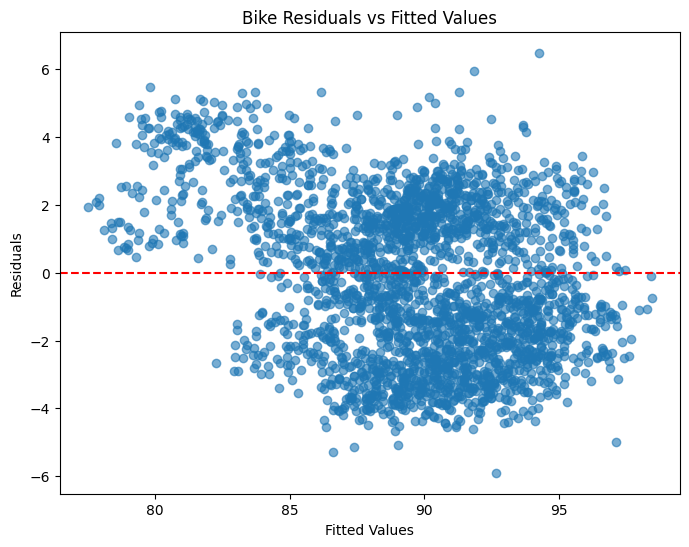

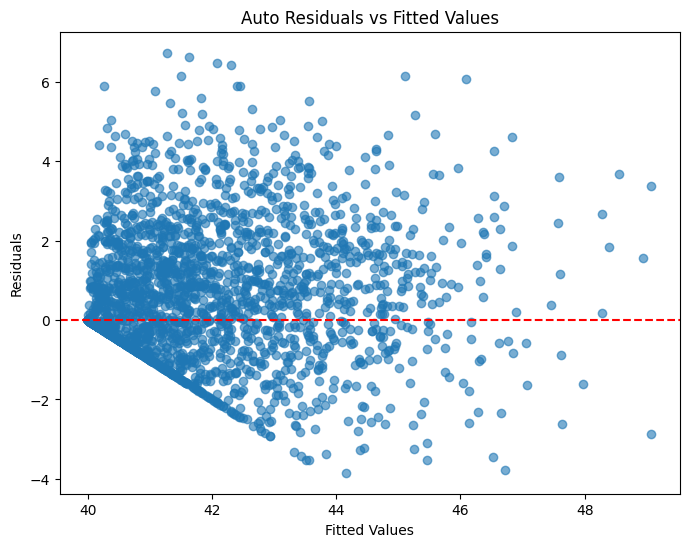

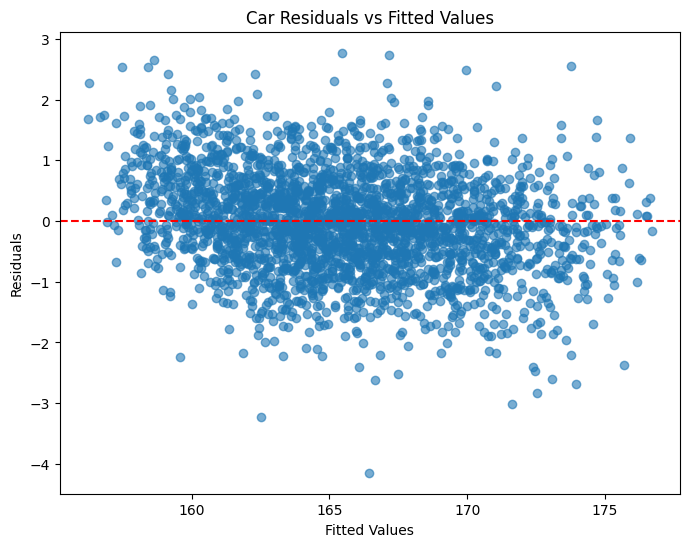

In [17]:
def plot_residuals_vs_fitted(residual_series, fitted_values, title_prefix):
    plt.figure(figsize=(8, 6))
    plt.scatter(fitted_values, residual_series, alpha=0.6)
    plt.axhline(0, color='red', linestyle='--')
    plt.title(f"{title_prefix} Residuals vs Fitted Values")
    plt.xlabel("Fitted Values")
    plt.ylabel("Residuals")
    plt.show()

fitted_bike = predictions_private['average_fare_bike']
plot_residuals_vs_fitted(residuals_df['residual_bike'], fitted_bike, "Bike")

fitted_auto = predictions_private['average_fare_auto']
plot_residuals_vs_fitted(residuals_df['residual_auto'], fitted_auto, "Auto")

fitted_car = predictions_private['average_fare_car']
plot_residuals_vs_fitted(residuals_df['residual_car'], fitted_car, "Car")


## ACF/PACF Plots

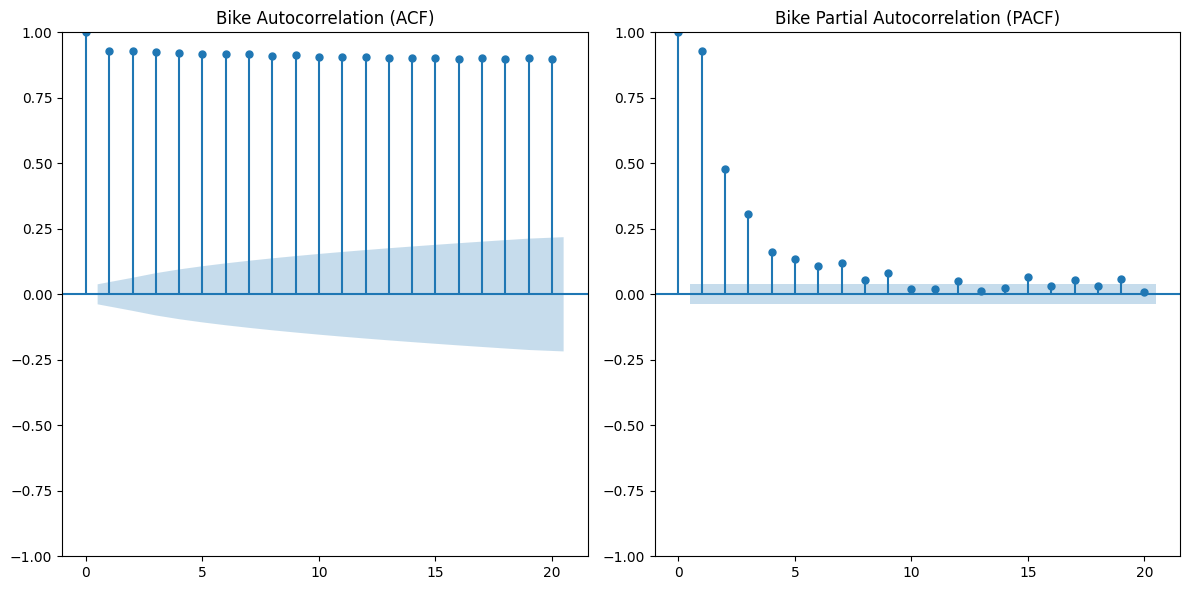

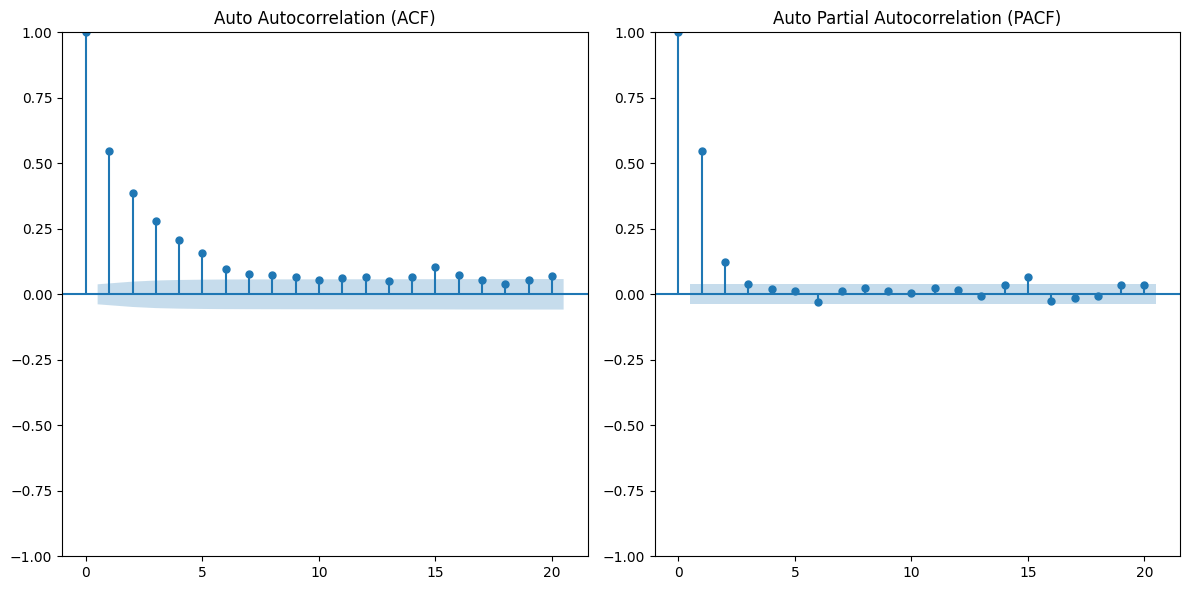

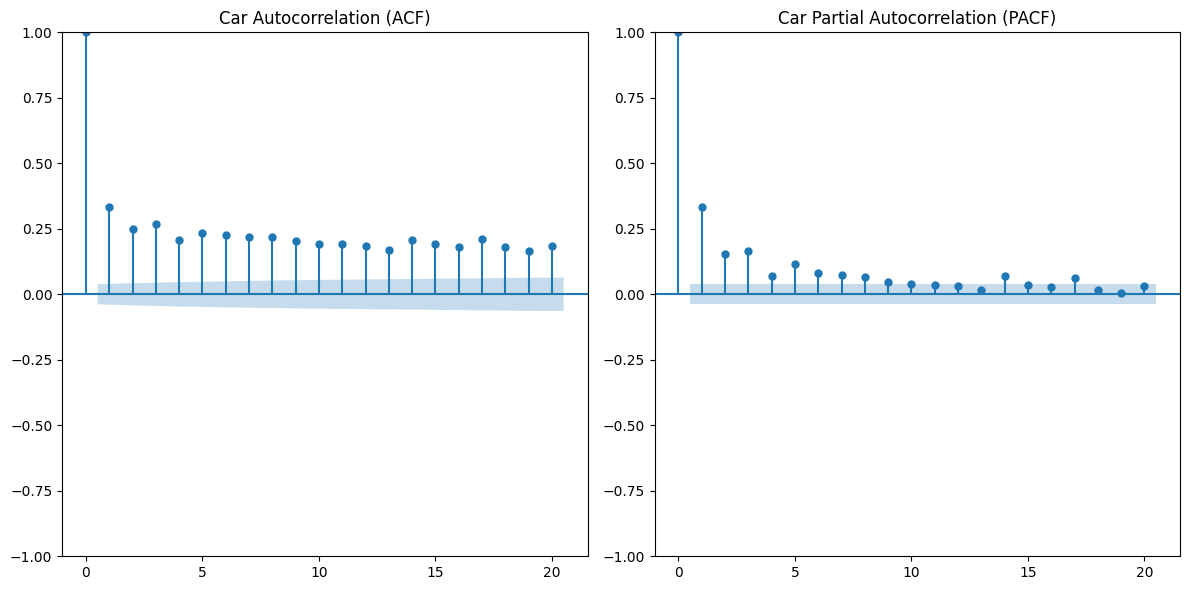

In [18]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Function to plot ACF and PACF
def plot_acf_pacf(residual_series, title_prefix):
    plt.figure(figsize=(12, 6))
    
    # ACF plot
    plt.subplot(1, 2, 1)
    plot_acf(residual_series, ax=plt.gca(), lags=20)
    plt.title(f"{title_prefix} Autocorrelation (ACF)")
    
    # PACF plot
    plt.subplot(1, 2, 2)
    plot_pacf(residual_series, ax=plt.gca(), lags=20, method='ywm')
    plt.title(f"{title_prefix} Partial Autocorrelation (PACF)")
    
    plt.tight_layout()
    plt.show()

# Call the function for each mode
plot_acf_pacf(residuals_df['residual_bike'], "Bike")
plot_acf_pacf(residuals_df['residual_auto'], "Auto")
plot_acf_pacf(residuals_df['residual_car'], "Car")


## Q-Q plots For Normality

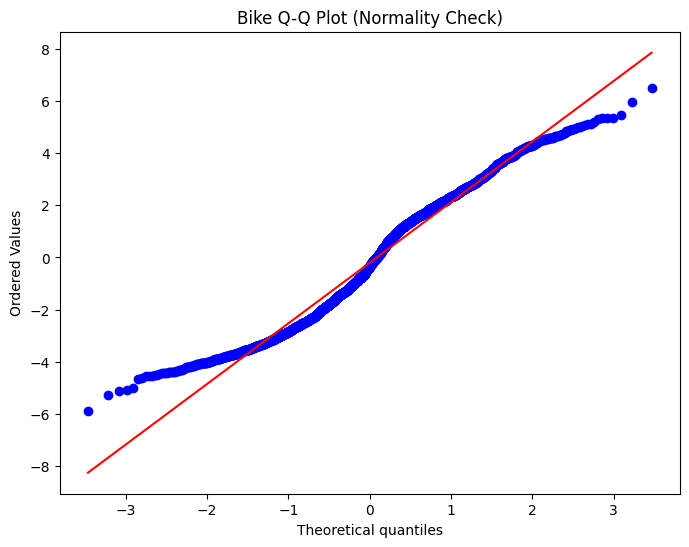

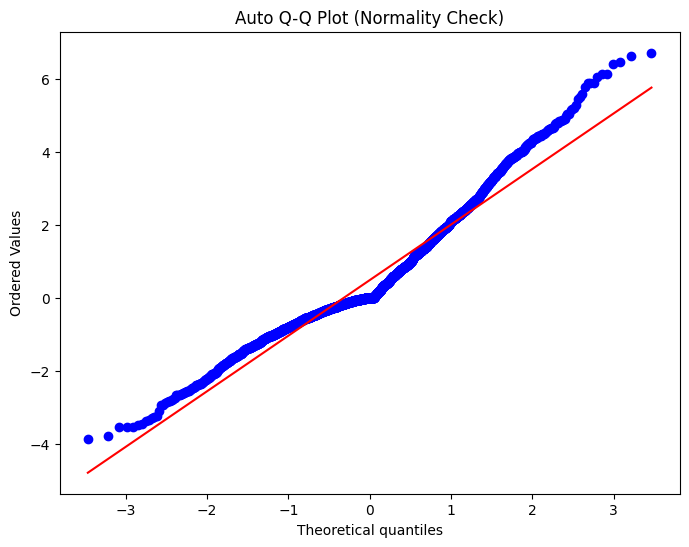

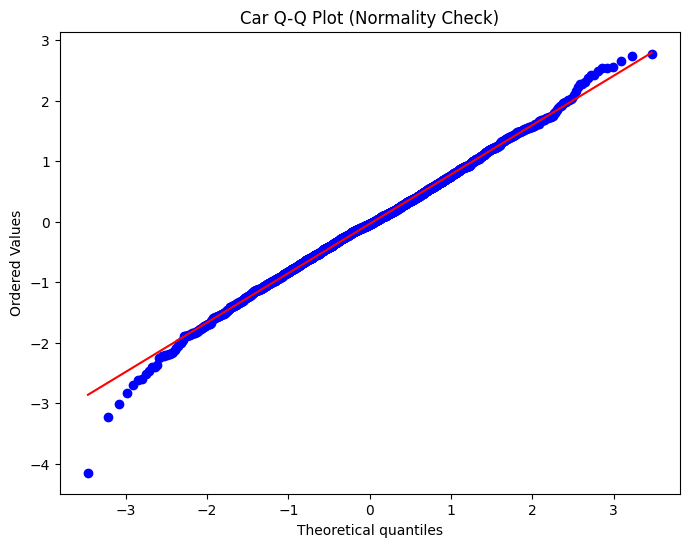

In [19]:
import scipy.stats as stats

# Function to plot Q-Q plot
def plot_qq(residual_series, title_prefix):
    plt.figure(figsize=(8, 6))
    stats.probplot(residual_series, dist="norm", plot=plt)
    plt.title(f"{title_prefix} Q-Q Plot (Normality Check)")
    plt.show()

# Call the function for each mode
plot_qq(residuals_df['residual_bike'], "Bike")
plot_qq(residuals_df['residual_auto'], "Auto")
plot_qq(residuals_df['residual_car'], "Car")


## Heteroscedasticity

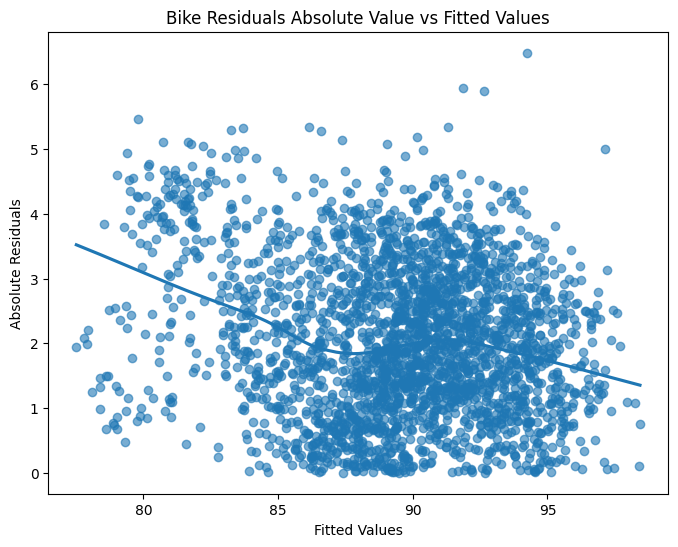

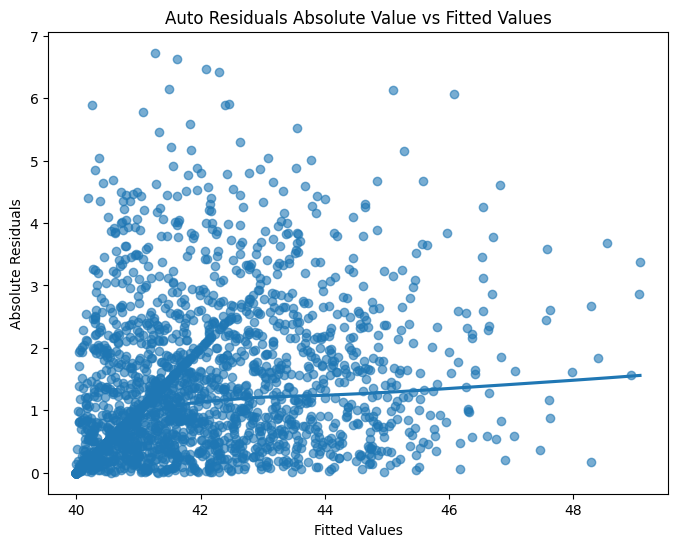

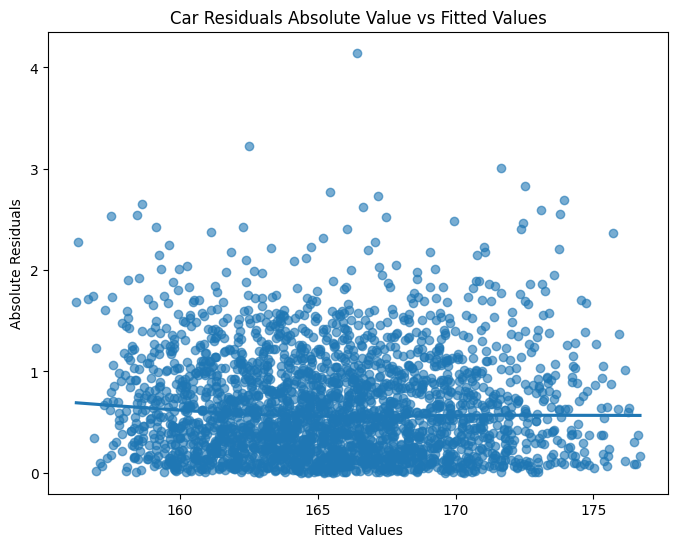

In [21]:
import seaborn as sns

def heteroscedasticity_plot(residual_series, fitted_values, title_prefix):
    plt.figure(figsize=(8, 6))
    sns.regplot(x=fitted_values, y=np.abs(residual_series), lowess=True, scatter_kws={'alpha': 0.6})
    plt.title(f"{title_prefix} Residuals Absolute Value vs Fitted Values")
    plt.xlabel("Fitted Values")
    plt.ylabel("Absolute Residuals")
    plt.show()

fitted_bike = predictions_private['average_fare_bike']
fitted_auto = predictions_private['average_fare_auto']
fitted_car = predictions_private['average_fare_car']

heteroscedasticity_plot(residuals_df['residual_bike'], fitted_bike, "Bike")
heteroscedasticity_plot(residuals_df['residual_auto'], fitted_auto, "Auto")
heteroscedasticity_plot(residuals_df['residual_car'], fitted_car, "Car")


# Critical Analysis

## Analysis Based Q-Q Plots, Residual vs Fitted Plots and Absolute Residuals Plots.

**Bike:**

- The residuals exhibit a slight funnel shape in the **residual vs. fitted plot**, indicating potential heteroscedasticity (variance of residuals increasing with fitted values).
- The **Q-Q plot** shows deviations at both ends, suggesting non-normality of residuals.
- The **absolute residuals plot** indicates that the model's predictions are less accurate for certain fitted value ranges.

**Auto:**

- The **residuals vs. fitted plot** displays a clear pattern, suggesting that the model has failed to capture some systematic trend or non-linearity in the data.
- The **Q-Q plot** shows heavy tails, further confirming that residuals are not normally distributed.
- The **absolute residuals plot** reveals an uneven distribution of errors, with errors increasing at higher fitted values, indicating heteroscedasticity.
  
**Car:**

- The **residuals vs. fitted plot** appears more balanced compared to the other models, with no clear patterns, indicating that the model captures the structure of the data relatively well.
- The **Q-Q plot** suggests mild deviations from normality but is closer to the theoretical line compared to the other models.
- The **absolute residuals plot** shows fairly constant variance, indicating homoscedasticity.

## **ACF and PACF Interpretation**

**Bike:**

- ACF Plot: The autocorrelation coefficients remain high and decrease very gradually over the lags, showing a slow decay.
- PACF Plot: A significant spike at lag 1, with a quick drop-off, suggests the series may follow an AR(1) process.

Conclusion: 
The slow decay in ACF indicates non-stationarity, likely due to a trend or strong seasonality. Differencing the data may be necessary to achieve stationarity.

**Auto:**

- ACF Plot: Exhibits significant correlations for the first few lags but decays more rapidly compared to the Bike series.
- PACF Plot: A sharp drop-off after lag 1 suggests the presence of an AR(1) process as a strong candidate model.

Conclusion: 
This series appears more stationary than the Bike series, though minor adjustments (e.g., differencing or detrending) may still improve model performance.

**Car:**

- ACF Plot: Shows a moderate decline in autocorrelations but remains significant for the first 10–15 lags.
- PACF Plot: A significant spike at lag 1, followed by a gradual tapering.

Conclusion:
This indicates a mix of AR and MA components, suggesting an ARIMA(p,d,q) model might be appropriate, with d=1d=1 to address potential non-stationarity.

## **Ljung-Box Test Results Interpretation**

The Ljung-Box test assesses whether residuals are white noise (uncorrelated). In all cases, p-values are effectively 0, indicating that the null hypothesis (residuals are white noise) is rejected. This suggests significant autocorrelation in the series.

**Bike:**

- Exceptionally high lb_statlb_stat values (e.g., 43679 at lag 20) suggest persistent autocorrelations over time, likely due to strong seasonality or a trend in the data.
- Actionable Insight: Differencing the series and examining the results could reduce autocorrelation.

**Auto:**

- Moderate lb_statlb_stat values (e.g., 1753 at lag 20) show residual autocorrelation, but to a lesser extent compared to Bike.
- Actionable Insight: A simple ARIMA model (with seasonal adjustments, if applicable) might suffice for this series.

**Car:**

- Lower lb_statlb_stat values (e.g., 2429 at lag 20) compared to Bike but still significant.
- Actionable Insight: This series might benefit from ARIMA or seasonal decomposition to capture both short-term and longer-term dependencies.

## Suggested Improvements And Reflection on What we Learned From Data

### Suggestions for Improvement:

- Data Transformations:
Apply Box-Cox or Yeo-Johnson transformations to stabilize variance.
Normalize or standardize input variables to improve model sensitivity.

- Feature Engineering:
Introduce and testing different lag features, interaction terms, or higher-order polynomial terms to capture missing non-linear relationships.

- Feature Selection:
Filter out only importance features based on permutation importance.

- Outlier Treatment:
Investigate and address outliers that are significantly affecting model predictions.

- Hyperparameter Tuning with Robust Cross Validation:
Using powerfull library for hyperparameter tuning like Optuna with different samplers would have definitely improved the score.


### Reflections

- The analysis highlights the importance of residual diagnostics in identifying model shortcomings and guiding improvements.
- It is evident that different models are better suited for different aspects of the data, emphasizing the need for hybrid or ensemble approaches.
- Future iterations should focus on incorporating domain knowledge and advanced feature engineering to address identified limitations effectively.
